INFO | Saved plot: ./plots\summary_row_1.png
INFO | Saved plot: ./plots\summary_row_2.png


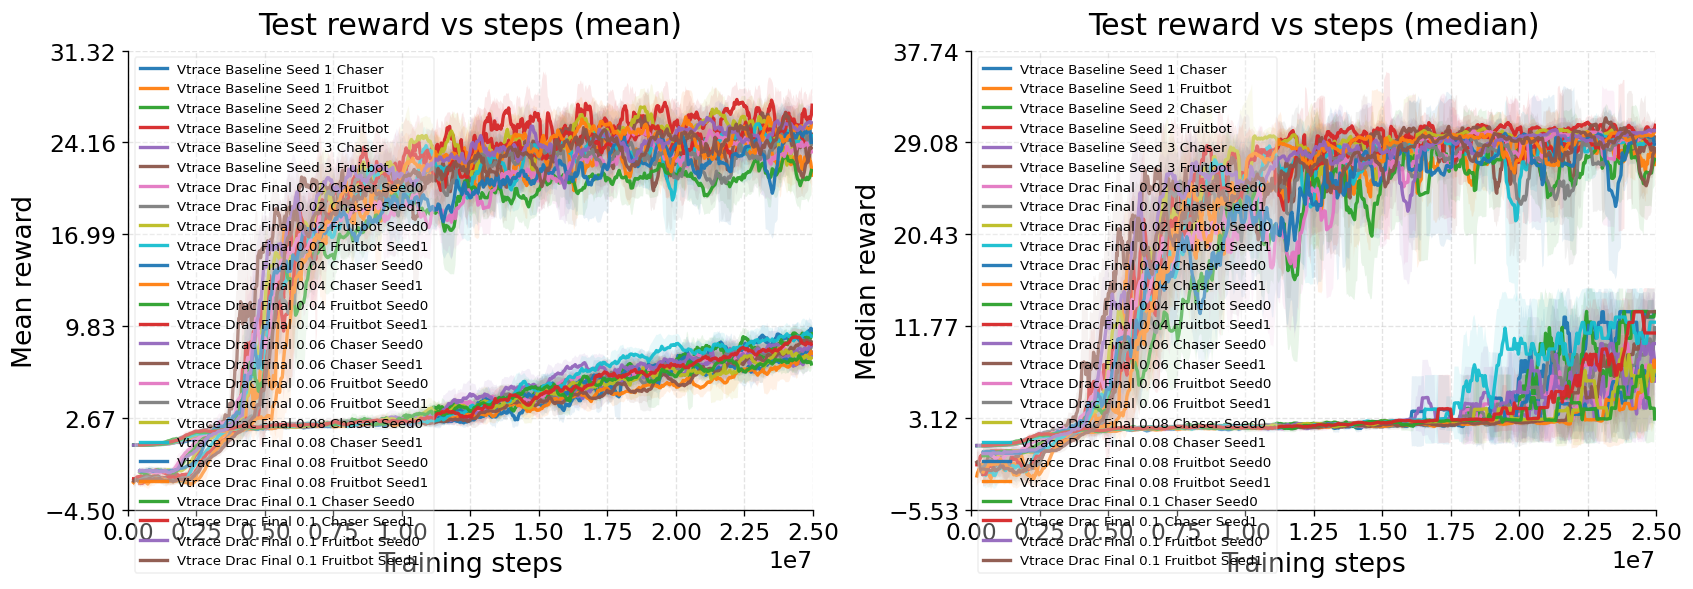

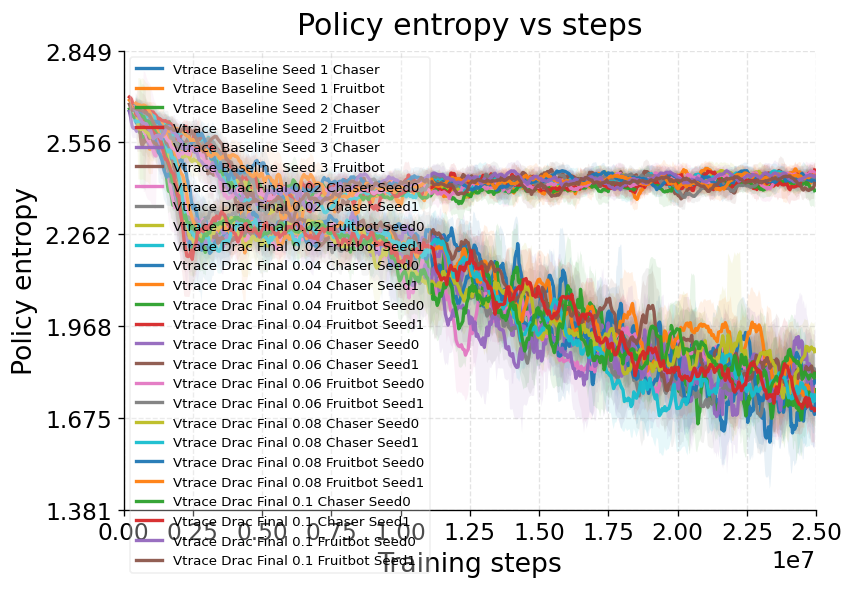

In [69]:
import logging
import math

import matplotlib

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"

REQUIRED_COLS = [
    "training_time",
    "total_steps",
    "test/mean_reward",
    "test/median_reward",
    "loss/dist_entropy",
]

PLOTS = [
    {"x": "steps", "y": "test/mean_reward", "xlabel": "Training steps", "ylabel": "Mean reward",
     "title": "Test reward vs steps (mean)"},
    {"x": "steps", "y": "test/median_reward", "xlabel": "Training steps", "ylabel": "Median reward",
     "title": "Test reward vs steps (median)"},
    {"x": "steps", "y": "loss/dist_entropy", "xlabel": "Training steps", "ylabel": "Policy entropy",
     "title": "Policy entropy vs steps"},
]

ROLL_WINDOW = 10
UNCERTAINTY_SCALE = 1.0
BAND_ALPHA = 0.10
STANDARD_ERROR_BANDS = False

COLS_PER_ROW = 2

MAX_STEPS = 25_000_000
USE_FINE_STEP = True

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger("sit_plot")


def ensure_dirs():
    os.makedirs(ROOT_DIR, exist_ok=True)
    os.makedirs(PLOTS_DIR, exist_ok=True)


def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    return sorted(paths)


def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")


def pretty_label_from_run(run_name):
    parts = run_name.split("/")
    pretty_parts = []
    for p in parts:
        p = p.replace("_", " ")
        p = p.replace("-", " ")
        p = " ".join(w.capitalize() for w in p.split() if w)
        pretty_parts.append(p)
    return " · ".join(pretty_parts)


def ensure_numeric(series, name):
    if series is None:
        raise ValueError(f"Column '{name}' missing")
    v = pd.to_numeric(series, errors="raise").astype(float).values
    if v.size == 0 or not np.isfinite(v).any():
        raise ValueError(f"Column '{name}' has no finite numeric values")
    return v


def build_steps(df):
    steps = ensure_numeric(df["total_steps"], "total_steps")
    s0 = np.nanmin(steps)
    if not np.isfinite(s0):
        raise ValueError("total_steps min not finite")
    if s0 != 0:
        steps = steps - s0
    return steps


def smooth_series(y):
    s = pd.Series(y, dtype=float)
    return s.rolling(ROLL_WINDOW, min_periods=ROLL_WINDOW).mean().values


def uncertainty_series(y):
    s = pd.Series(y, dtype=float)
    std = s.rolling(ROLL_WINDOW, min_periods=ROLL_WINDOW).std(ddof=1)
    if STANDARD_ERROR_BANDS:
        se = std / np.sqrt(ROLL_WINDOW)
        return se.values
    return std.values


def load_runs(root):
    paths = find_run_csvs(root, CSV_NAME)
    if not paths:
        logger.error(f"No CSVs named '{CSV_NAME}' found under root='{root}'")
        return pd.DataFrame()
    frames = []
    for p in paths:
        run = infer_run_name(p, root)
        run_label = pretty_label_from_run(run)
        try:
            df = pd.read_csv(p)
            missing = [c for c in REQUIRED_COLS if c not in df.columns]
            if missing:
                raise ValueError(f"Missing required columns: {missing}")
            steps = build_steps(df)
            y_mean = ensure_numeric(df["test/mean_reward"], "test/mean_reward")
            y_median = ensure_numeric(df["test/median_reward"], "test/median_reward")
            entropy_col = ensure_numeric(df["loss/dist_entropy"], "loss/dist_entropy")
            sub = pd.DataFrame({
                "run": run,
                "run_label": run_label,
                "steps": steps,
                "test/mean_reward": y_mean,
                "test/median_reward": y_median,
                "loss/dist_entropy": entropy_col,
            })
            sub = sub.sort_values("steps")
            frames.append(sub)
        except Exception as e:
            logger.error(f"[{run}] skipping due to error: {e}")
            continue
    if not frames:
        logger.error("No valid runs loaded after strict validation")
        return pd.DataFrame()
    df_all = pd.concat(frames, ignore_index=True)
    return df_all


def set_fixed_step_ticks(ax):
    if USE_FINE_STEP:
        step = 2_500_000
    else:
        step = 5_000_000
    ticks = np.arange(0, MAX_STEPS + 1, step)
    ax.set_xticks(ticks)
    ax.set_xlim(0, MAX_STEPS)


def set_more_y_ticks(ax, n_y=6):
    ymin, ymax = ax.get_ylim()
    if np.isfinite(ymin) and np.isfinite(ymax) and ymax > ymin:
        ys = np.linspace(ymin, ymax, n_y)
        ax.set_yticks(ys)


def plot_runs(ax, df, runs, x, y, xlabel, ylabel, title):
    plotted_any = False
    for r in runs:
        d = df[df["run"] == r]
        xv = d[x].values
        yv = d[y].values
        if yv.size == 0 or np.all(~np.isfinite(yv)):
            logger.error(f"[{r}] plot '{title}' y='{y}' invalid; strict mode skips")
            continue
        ys = smooth_series(yv)
        u = uncertainty_series(yv)
        mask = np.isfinite(xv) & np.isfinite(ys) & np.isfinite(u)
        xv2, ys2, u2 = xv[mask], ys[mask], u[mask]
        if xv2.size == 0:
            logger.error(f"[{r}] plot '{title}' insufficient finite points after smoothing")
            continue
        label = d["run_label"].iloc[0] if "run_label" in d.columns and not d["run_label"].isna().all() else r
        ax.plot(xv2, ys2, label=label, linewidth=2.0, alpha=0.95)
        ax.fill_between(xv2, ys2 - UNCERTAINTY_SCALE * u2, ys2 + UNCERTAINTY_SCALE * u2, alpha=BAND_ALPHA, linewidth=0)
        plotted_any = True
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if x == "steps":
        set_fixed_step_ticks(ax)
    ax.grid(True, alpha=0.35)
    set_more_y_ticks(ax)
    if plotted_any:
        ax.legend(loc="best", fontsize=8, framealpha=0.3)
    else:
        logger.error(f"No lines plotted for '{title}'")


def safe_filename(s):
    return "".join(c if c.isalnum() or c in "-_." else "_" for c in s).lower()


def save_plot(fig, name, dpi=200):
    os.makedirs(PLOTS_DIR, exist_ok=True)
    fname = safe_filename(name)
    path_png = os.path.join(PLOTS_DIR, f"{fname}.png")
    fig.savefig(path_png, dpi=dpi, bbox_inches="tight")
    logger.info(f"Saved plot: {path_png}")


def main():
    ensure_dirs()
    try:
        matplotlib.rcParams["figure.dpi"] = 120
        matplotlib.rcParams["savefig.dpi"] = 200
        matplotlib.rcParams["axes.spines.top"] = False
        matplotlib.rcParams["axes.spines.right"] = False
        matplotlib.rcParams["grid.linestyle"] = "--"
        matplotlib.rcParams["legend.frameon"] = True
        try:
            plt.rcParams["text.usetex"] = False
        except Exception:
            pass
    except Exception:
        pass
    df = load_runs(ROOT_DIR)
    if df.empty:
        print(f"No {CSV_NAME} files with required columns found under: {ROOT_DIR}")
        return
    runs = df["run"].unique().tolist()
    if not runs:
        print(f"No valid runs after strict validation under: {ROOT_DIR}")
        return

    n_plots = len(PLOTS)
    n_rows = math.ceil(n_plots / COLS_PER_ROW)
    for row_idx in range(n_rows):
        start = row_idx * COLS_PER_ROW
        end = min(start + COLS_PER_ROW, n_plots)
        row_cfgs = PLOTS[start:end]

        fig, axes = plt.subplots(1, len(row_cfgs), figsize=(7 * len(row_cfgs), 4.8), constrained_layout=True)
        if len(row_cfgs) == 1:
            axes = [axes]

        for ax, cfg in zip(axes, row_cfgs):
            plot_runs(ax, df, runs, **cfg)

        row_title = f"summary_row_{row_idx + 1}"
        save_plot(fig, row_title)

    plt.show()


if __name__ == "__main__":
    main()


,run,p,m,mean_max
0,vtrace_baseline_seed_1_chaser,NaN,NaN,10.8287
1,vtrace_baseline_seed_1_fruitbot,NaN,NaN,27.3281
2,vtrace_baseline_seed_2_chaser,NaN,NaN,10.3025
3,vtrace_baseline_seed_2_fruitbot,NaN,NaN,29.9688
4,vtrace_baseline_seed_3_chaser,NaN,NaN,9.6725
5,vtrace_baseline_seed_3_fruitbot,NaN,NaN,28.9844
6,vtrace_drac_final_0.02_chaser_seed0,NaN,NaN,9.2025
7,vtrace_drac_final_0.02_chaser_seed1,NaN,NaN,9.7350
8,vtrace_drac_final_0.02_fruitbot_seed0,NaN,NaN,29.6094
9,vtrace_drac_final_0.02_fruitbot_seed1,NaN,NaN,28.2188


,p,m,mean_max


C:\Users\sandr\AppData\Local\Temp\ipykernel_20096\3995332417.py:108: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm, interpolation="nearest")
C:\Users\sandr\AppData\Local\Temp\ipykernel_20096\3995332417.py:108: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm, interpolation="nearest")


Saved heatmap to './plots\mean_reward_matrix.png'


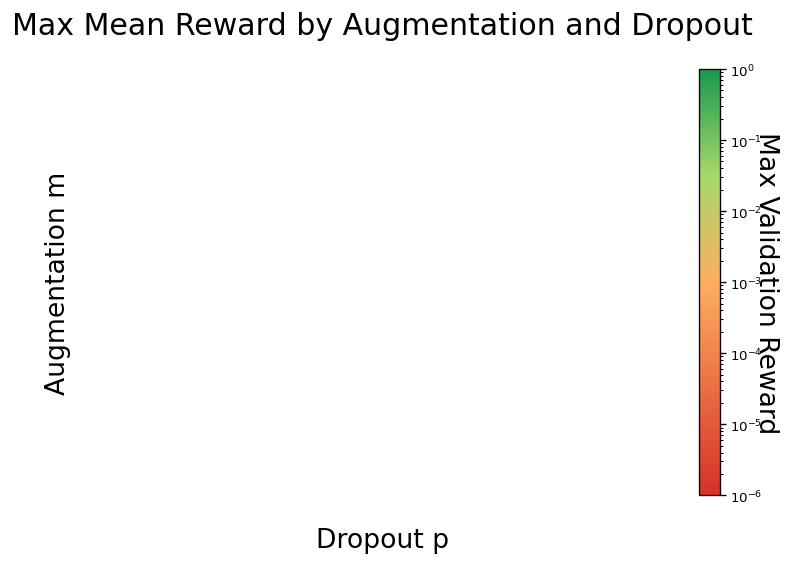

In [70]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, SymLogNorm
from typing import List, Tuple, Dict, Any

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"
PNG_NAME = "mean_reward_matrix.png"

Y_MEAN = "test/mean_episode_reward"
Y_MEAN_ALIASES = [Y_MEAN, "test/mean_reward"]

def find_run_csvs(root: str, csv_name: str) -> List[str]:
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    paths = sorted(paths)
    return paths

def infer_run_name(path: str, root: str) -> str:
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def parse_p_m_from_run(run_name: str) -> Tuple[float, float]:
    p_match = re.search(r"p([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    m_match = re.search(r"m([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    p = float(p_match.group(1)) if p_match else np.nan
    m = float(m_match.group(1)) if m_match else np.nan
    return p, m

def get_first_present(df: pd.DataFrame, names: List[str]) -> str | None:
    for n in names:
        if n in df.columns:
            return n
    return None

def mean_max(series: pd.Series | List[Any]) -> float:
    x = pd.to_numeric(pd.Series(series), errors="coerce").dropna().values
    if x.size == 0:
        return np.nan
    return float(np.max(x))

def load_metrics_max_mean(root: str) -> List[Dict[str, Any]]:
    paths = find_run_csvs(root, CSV_NAME)
    rows = []
    for pth in paths:
        run = infer_run_name(pth, root)
        try:
            df = pd.read_csv(pth)
        except Exception:
            continue
        y_mean_col = get_first_present(df, Y_MEAN_ALIASES)
        if y_mean_col is None:
            continue
        mean_series = df.get(y_mean_col, pd.Series(dtype=float))
        mean_est = mean_max(mean_series)
        if np.isnan(mean_est):
            continue
        p_val, m_val = parse_p_m_from_run(run)
        rows.append({"run": run, "p": p_val, "m": m_val, "mean_max": mean_est})
    return rows

def build_matrix(rows: List[Dict[str, Any]]) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    df = pd.DataFrame(rows)
    if df.empty:
        return np.array([]), np.array([]), np.array([[]]), pd.DataFrame(columns=["p","m","mean_max"])
    P_vals = np.sort(df["p"].dropna().unique())
    M_vals = np.sort(df["m"].dropna().unique())
    mean_matrix = np.full((len(P_vals), len(M_vals)), np.nan, dtype=float)
    grouped = df.groupby(["p", "m"], dropna=False).agg({"mean_max": "mean"}).reset_index()
    p_index = {p: i for i, p in enumerate(P_vals)}
    m_index = {m: j for j, m in enumerate(M_vals)}
    for _, row in grouped.iterrows():
        p, m = row["p"], row["m"]
        if p in p_index and m in m_index:
            i, j = p_index[p], m_index[m]
            mean_matrix[i, j] = row["mean_max"]
    tidy = pd.DataFrame({
        "p": np.repeat(P_vals, len(M_vals)),
        "m": np.tile(M_vals, len(P_vals)),
        "mean_max": mean_matrix.reshape(-1),
    })
    return P_vals, M_vals, mean_matrix, tidy

def make_green_good_red_bad_cmap() -> LinearSegmentedColormap:
    colors = [(0.0, "#d73027"), (0.5, "#fdae61"), (0.75, "#a6d96a"), (1.0, "#1a9850")]
    return LinearSegmentedColormap.from_list("red_yellow_green", colors)

def _auto_norm(matrix: np.ndarray):
    finite_vals = matrix[np.isfinite(matrix)]
    if finite_vals.size == 0:
        return 0.0, 1.0, LogNorm(vmin=1e-6, vmax=1.0)
    vmin, vmax = np.nanmin(finite_vals), np.nanmax(finite_vals)
    if np.isclose(vmin, vmax):
        delta = 1.0 if vmax == 0 else abs(vmax) * 0.1
        vmin, vmax = vmax - delta, vmax + delta
    if np.all(finite_vals > 0):
        eps = np.nextafter(0, 1)
        return vmin, vmax, LogNorm(vmin=max(vmin, eps), vmax=vmax)
    linthresh = max(1e-6, 0.01 * max(1e-9, (vmax - vmin)))
    return vmin, vmax, SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)

def _imshow(ax, matrix: np.ndarray, P_vals: np.ndarray, M_vals: np.ndarray, title: str, fig: plt.Figure, cmap: LinearSegmentedColormap):
    vmin, vmax, norm = _auto_norm(matrix)
    im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm, interpolation="nearest")
    ax.set_title(title, pad=6)
    ax.set_ylabel("Augmentation m", labelpad=4)
    ax.set_xlabel("Dropout p", labelpad=4)
    ax.set_xticks(range(len(M_vals)))
    ax.set_yticks(range(len(P_vals)))
    ax.set_xticklabels([f"{m:g}" for m in M_vals], rotation=35, ha="right")
    ax.set_yticklabels([f"{p:g}" for p in P_vals])
    ax.tick_params(axis="both", which="both", labelsize=8, pad=2)
    im.cmap.set_bad(color="#bdbdbd")
    im.set_data(np.ma.masked_invalid(matrix))
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
    cbar.ax.tick_params(labelsize=8, pad=2)
    cbar.ax.set_ylabel("Max Validation Reward", rotation=270, labelpad=10)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

def ensure_dir(path: str):
    try:
        os.makedirs(path, exist_ok=True)
    except Exception:
        pass

def main():
    rows = load_metrics_max_mean(ROOT_DIR)
    if not rows:
        print(f"No valid runs found to build matrix from: {ROOT_DIR}")
        return
    P_vals, M_vals, mean_matrix, tidy = build_matrix(rows)
    try:
        display(pd.DataFrame(rows))
        display(tidy)
    except NameError:
        print(pd.DataFrame(rows).head())
        print(tidy.head())

    plt.rcParams.update({
        "font.size": 16,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.titlepad": 6,
    })

    fig, ax = plt.subplots(1, 1, figsize=(6.2, 4.6), constrained_layout=True)
    cmap = make_green_good_red_bad_cmap()
    _imshow(ax, mean_matrix, P_vals, M_vals, "Max Mean Reward by Augmentation and Dropout", fig, cmap)
    ensure_dir(PLOTS_DIR)
    out_path = os.path.join(PLOTS_DIR, PNG_NAME)
    try:
        fig.savefig(out_path, bbox_inches="tight")
        print(f"Saved heatmap to '{out_path}'")
    except Exception:
        print(f"Failed to save figure to '{out_path}'")
    plt.show()

if __name__ == "__main__":
    main()


Saved: ./plots\vtrace_drac_chaser_fruitbot.png


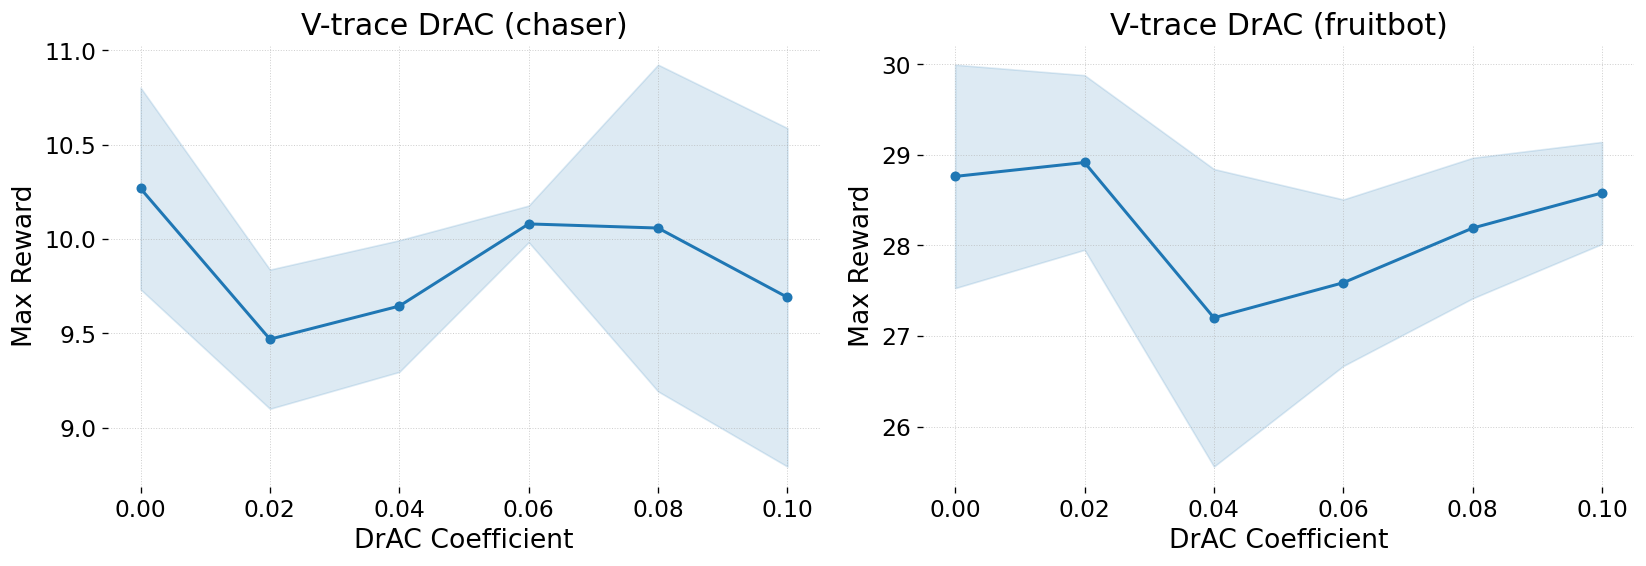

In [74]:

import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"
OUT_NAME = "vtrace_drac_chaser_fruitbot.png"
Y_MEAN_ALIASES = ["test/mean_episode_reward", "test/mean_reward"]

def find_run_csvs(root, csv_name):
    out = []
    for d, _, f in os.walk(root):
        if csv_name in f:
            out.append(os.path.join(d, csv_name))
    return sorted(out)

def infer_run_name(path, root):
    return os.path.relpath(os.path.dirname(path), root).replace("\\", "/")

def parse_tokens(run):
    if "baseline" in run:
        env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
        return {"algo": "vtrace", "drac": "baseline", "drac_val": 0.0, "env": env}
    m = re.search(r"final_([0-9]*\.?[0-9]+(?:[eE][+\-]?\d+)?)_", run)
    drac_val = float(m.group(1)) if m else np.nan
    env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
    algo = "vtrace" if run.startswith("vtrace") else None
    drac = "drac" if "_drac_" in run else None
    return {"algo": algo, "drac": drac, "drac_val": drac_val, "env": env}

def get_first_present(df, cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

def compute_reward_max(s):
    x = pd.to_numeric(pd.Series(s), errors="coerce").dropna().values.astype(float)
    if x.size == 0:
        return np.nan
    return float(np.max(x))

def load_rows(root):
    rows = []
    for p in find_run_csvs(root, CSV_NAME):
        run = infer_run_name(p, root)
        t = parse_tokens(run)
        if t["algo"] != "vtrace":
            continue
        if t["env"] not in ("fruitbot", "chaser"):
            continue
        if t["drac"] not in ("drac", "baseline"):
            continue
        try:
            df = pd.read_csv(p)
        except:
            continue
        y = get_first_present(df, Y_MEAN_ALIASES)
        if not y:
            continue
        val = compute_reward_max(df[y])
        if np.isnan(val):
            continue
        rows.append({
            "run": run,
            "env": t["env"],
            "drac": float(t["drac_val"]),
            "reward_max": val
        })
    return rows

def plot_side_by_side(df_chaser, df_fruitbot, out_dir, filename):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    for ax, df_env, env in [
        (axs[0], df_chaser, "chaser"),
        (axs[1], df_fruitbot, "fruitbot")
    ]:
        if df_env.empty:
            continue

        dfg = df_env.groupby("drac")
        xs, means, lowers, uppers = [], [], [], []

        for drac, subdf in dfg:
            vals = subdf["reward_max"].dropna().values.astype(float)
            if vals.size == 0:
                continue
            mu = float(np.mean(vals))
            se = float(np.std(vals) / np.sqrt(len(vals)))
            xs.append(float(drac))
            means.append(mu)
            lowers.append(mu - 1.96 * se)
            uppers.append(mu + 1.96 * se)

        xs = np.array(xs, float)
        order = np.argsort(xs)
        xs = xs[order]
        means = np.array(means)[order]
        lowers = np.array(lowers)[order]
        uppers = np.array(uppers)[order]

        ax.plot(xs, means, marker="o", linewidth=1.8, markersize=5, color="#1f77b4")
        ax.fill_between(xs, lowers, uppers, color="#1f77b4", alpha=0.15)
        ax.set_title(f"V-trace DrAC ({env})")
        ax.set_xlabel("DrAC Coefficient")
        ax.set_ylabel("Max Reward")
        ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
        for s in ax.spines.values():
            s.set_visible(False)

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, filename)
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    print("Saved:", out_path)
    plt.show()

def main():
    rows = load_rows(ROOT_DIR)
    if not rows:
        print("No runs found")
        return
    df = pd.DataFrame(rows)
    df_chaser = df[df["env"] == "chaser"]
    df_fruitbot = df[df["env"] == "fruitbot"]
    plot_side_by_side(df_chaser, df_fruitbot, PLOTS_DIR, OUT_NAME)

if __name__ == "__main__":
    main()


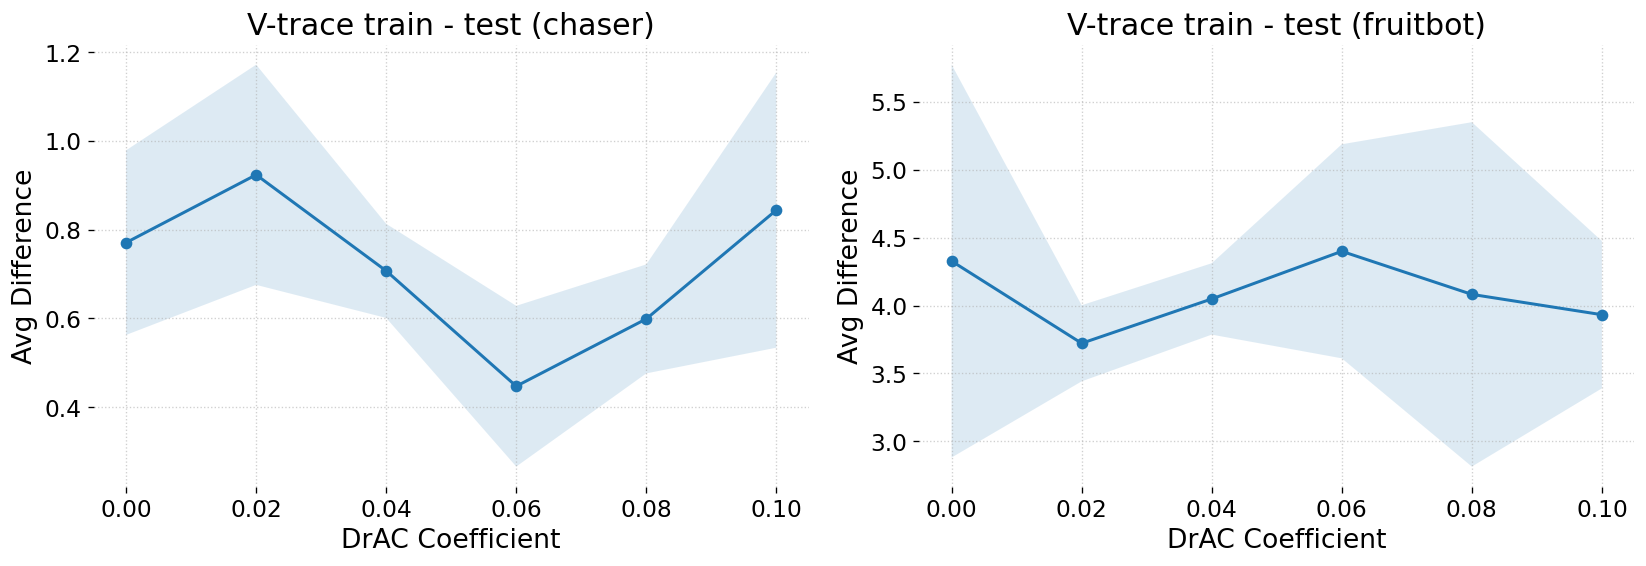

In [75]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"
PLOTS_DIR = "./plots"
OUT_NAME = "vtrace_drac_chaser_fruitbot.png"
OUT_NAME_DIFF = "vtrace_drac_train_test_diff.png"

Y_TEST = ["test/mean_episode_reward", "test/mean_reward"]
Y_TRAIN = ["train/mean_episode_reward", "train/mean_reward"]
LAST_N_ROWS = 50

def find_run_csvs(root, csv_name):
    out = []
    for d, _, f in os.walk(root):
        if csv_name in f:
            out.append(os.path.join(d, csv_name))
    return sorted(out)

def infer_run_name(path, root):
    return os.path.relpath(os.path.dirname(path), root).replace("\\", "/")

def parse_tokens(run):
    if "baseline" in run:
        env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
        return {"algo": "vtrace", "drac": "baseline", "drac_val": 0.0, "env": env}
    m = re.search(r"final_([0-9]*\.?[0-9]+(?:[eE][+\-]?\d+)?)_", run)
    drac_val = float(m.group(1)) if m else np.nan
    env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
    algo = "vtrace" if run.startswith("vtrace") else None
    drac = "drac" if "_drac_" in run else None
    return {"algo": algo, "drac": drac, "drac_val": drac_val, "env": env}

def get_first_present(df, cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

def load_rows(root):
    rows = []
    for p in find_run_csvs(root, CSV_NAME):
        run = infer_run_name(p, root)
        t = parse_tokens(run)
        if t["algo"] != "vtrace":
            continue
        if t["env"] not in ("fruitbot", "chaser"):
            continue
        if t["drac"] not in ("drac", "baseline"):
            continue
        try:
            df = pd.read_csv(p)
        except:
            continue

        df_last = df.tail(LAST_N_ROWS)

        test_col = get_first_present(df_last, Y_TEST)
        train_col = get_first_present(df_last, Y_TRAIN)

        if test_col:
            v = pd.to_numeric(df_last[test_col], errors="coerce").dropna().values
            if v.size > 0:
                rows.append({"run": run, "env": t["env"], "drac": float(t["drac_val"]), "kind": "test", "reward": float(np.mean(v))})

        if train_col:
            v = pd.to_numeric(df_last[train_col], errors="coerce").dropna().values
            if v.size > 0:
                rows.append({"run": run, "env": t["env"], "drac": float(t["drac_val"]), "kind": "train", "reward": float(np.mean(v))})

    return rows

def get_latest_n(df, n):
    return df.sort_values("run").groupby(["env", "drac", "kind"]).tail(n)

def compute_differences(df):
    df_t = df[df["kind"] == "test"][["run", "env", "drac", "reward"]]
    df_r = df[df["kind"] == "train"][["run", "env", "drac", "reward"]]
    m = pd.merge(df_t, df_r, on=["run", "env", "drac"], suffixes=("_test", "_train"))
    m["diff"] = m["reward_train"] - m["reward_test"]
    return m

def plot_test(df_chaser, df_fruitbot, out_dir, filename):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    for ax, df_env, env in [(axs[0], df_chaser, "chaser"), (axs[1], df_fruitbot, "fruitbot")]:
        if df_env.empty:
            continue
        dfg = df_env.groupby("drac")
        xs, means, lowers, uppers = [], [], [], []
        for drac, g in dfg:
            vals = g["reward"].dropna().values
            mu = float(np.mean(vals))
            se = float(np.std(vals) / np.sqrt(len(vals)))
            xs.append(drac)
            means.append(mu)
            lowers.append(mu - 1.96 * se)
            uppers.append(mu + 1.96 * se)
        xs = np.array(xs)
        order = np.argsort(xs)
        xs = xs[order]
        means = np.array(means)[order]
        lowers = np.array(lowers)[order]
        uppers = np.array(uppers)[order]
        ax.plot(xs, means, marker="o", linewidth=1.8)
        ax.fill_between(xs, lowers, uppers, alpha=0.15)
        ax.set_title(f"V-trace DrAC test ({env})")
        ax.set_xlabel("DrAC Coefficient")
        ax.set_ylabel("Avg Reward")
        ax.grid(True, linestyle=":", alpha=0.6)
        for s in ax.spines.values():
            s.set_visible(False)
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, filename), bbox_inches="tight")
    plt.show()
    plt.close()

def plot_difference(df_chaser, df_fruitbot, out_dir, filename):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    for ax, df_env, env in [(axs[0], df_chaser, "chaser"), (axs[1], df_fruitbot, "fruitbot")]:
        if df_env.empty:
            continue
        dfg = df_env.groupby("drac")
        xs, means, lowers, uppers = [], [], [], []
        for drac, g in dfg:
            vals = g["diff"].dropna().values
            mu = float(np.mean(vals))
            se = float(np.std(vals) / np.sqrt(len(vals)))
            xs.append(drac)
            means.append(mu)
            lowers.append(mu - 1.96 * se)
            uppers.append(mu + 1.96 * se)
        xs = np.array(xs)
        order = np.argsort(xs)
        xs = xs[order]
        means = np.array(means)[order]
        lowers = np.array(lowers)[order]
        uppers = np.array(uppers)[order]
        ax.plot(xs, means, marker="o", linewidth=1.8)
        ax.fill_between(xs, lowers, uppers, alpha=0.15)
        ax.set_title(f"V-trace train - test ({env})")
        ax.set_xlabel("DrAC Coefficient")
        ax.set_ylabel("Avg Difference")
        ax.grid(True, linestyle=":", alpha=0.6)
        for s in ax.spines.values():
            s.set_visible(False)
    os.makedirs(out_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, filename), bbox_inches="tight")
    plt.show()
    plt.close()

def main():
    rows = load_rows(ROOT_DIR)
    if not rows:
        print("No runs found")
        return

    df = pd.DataFrame(rows)
    df_latest = get_latest_n(df, 5)

    diff = compute_differences(df_latest)
    diff_chaser = diff[diff["env"] == "chaser"]
    diff_fruitbot = diff[diff["env"] == "fruitbot"]

    plot_difference(diff_chaser, diff_fruitbot, PLOTS_DIR, OUT_NAME_DIFF)

if __name__ == "__main__":
    main()


In [73]:
import json

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"
Y_MEAN_ALIASES = ["test/mean_episode_reward", "test/mean_reward"]


def find_run_csvs(root, csv_name):
    out = []
    for d, _, f in os.walk(root):
        if csv_name in f:
            out.append(os.path.join(d, csv_name))
    return sorted(out)


def infer_run_name(path, root):
    return os.path.relpath(os.path.dirname(path), root).replace("\\", "/")


def parse_tokens(run):
    if "baseline" in run:
        env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
        return {"algo": "vtrace", "drac": "baseline", "drac_val": 0.0, "env": env}
    m = re.search(r"final_([0-9]*\.?[0-9]+(?:[eE][+\-]?\d+)?)_", run)
    drac_val = float(m.group(1)) if m else np.nan
    env = "fruitbot" if "fruitbot" in run else ("chaser" if "chaser" in run else None)
    algo = "vtrace" if run.startswith("vtrace") else None
    drac = "drac" if "_drac_" in run else None
    return {"algo": algo, "drac": drac, "drac_val": drac_val, "env": env}


def get_first_present(df, cols):
    for c in cols:
        if c in df.columns:
            return c
    return None


def compute_reward_max(s):
    x = pd.to_numeric(pd.Series(s), errors="coerce").dropna().values.astype(float)
    if x.size == 0:
        return np.nan
    return float(np.max(x))


def load_rows(root):
    rows = []
    for p in find_run_csvs(root, CSV_NAME):
        run = infer_run_name(p, root)
        t = parse_tokens(run)
        if t["algo"] != "vtrace":
            continue
        if t["env"] not in ("fruitbot", "chaser"):
            continue
        if t["drac"] not in ("drac", "baseline"):
            continue
        try:
            df = pd.read_csv(p)
        except:
            continue
        y = get_first_present(df, Y_MEAN_ALIASES)
        if not y or "training_time" not in df.columns:
            continue
        val = compute_reward_max(df[y])
        if np.isnan(val):
            continue
        tt = df["training_time"].dropna().values
        tt = float(np.mean(tt)) if len(tt) > 0 else np.nan
        rows.append({"env": t["env"], "drac": float(t["drac_val"]), "reward_max": val, "training_time": tt})
    return rows


def compute_time_stats(df):
    out = {}
    for env in ["chaser", "fruitbot"]:
        dfe = df[df["env"] == env]
        base = dfe[dfe["drac"] == 0.0]["training_time"].dropna().values
        drac = dfe[dfe["drac"] != 0.0]["training_time"].dropna().values
        if len(base) == 0 or len(drac) == 0:
            out[env] = None
            continue
        out[env] = {
            "baseline": float(np.mean(base)),
            "drac": float(np.mean(drac)),
            "ratio": float(np.mean(drac) / np.mean(base))
        }
    return out


def main():
    rows = load_rows(ROOT_DIR)
    if not rows:
        print("No runs found")
        return
    df = pd.DataFrame(rows)
    stats = compute_time_stats(df)
    print(json.dumps(stats, indent=2))


if __name__ == "__main__":
    main()


{
  "chaser": {
    "baseline": 983.8615916432803,
    "drac": 1442.3226926407767,
    "ratio": 1.4659812974625408
  },
  "fruitbot": {
    "baseline": 975.4920082631743,
    "drac": 1640.8664001165048,
    "ratio": 1.6820910742651842
  }
}
